# VAE IN PYTORCH RUNNING IN CROMWELL CONNECTED TO NEPTUNE

In this example I log in neptune:
1. images
2. model architecture
3. model weights
4. numerical metrics 
5. source code

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import numpy
import neptune
from MODULES.utilities import *
from MODULES.vae_model import * 
from MODULES.utilities_neptune import *

#pip install psutil
#pip install neptune-client

### read the parameters

In [4]:
params = load_json_as_dict("./ML_parameters.json")
print(params)

{'neptune_project': 'dalessioluca/cromwell', 'architecture': {'__comment': 'parameters specifying the architecture of the model', 'dim_z': 25, 'width_input_image': 28, 'ch_input_image': 1}, 'simulation': {'MAX_EPOCHS': 500, 'TEST_FREQUENCY': 5, 'CHECKPOINT_FREQUENCY': 20, 'BATCH_SIZE': 128}, 'GECO_loss': {'__comment': 'if active=false use ELBO, else use GECO with Log-Likelihood threshold = n_pixels * n_channel * threshold', 'is_active': True, 'factor_balance_range': [0.1, 0.8, 0.9], 'target_mse': [0.75, 1.0], 'fg_std': 0.05}, 'optimizer': {'__comment': 'which optimizer to use', 'type': 'adam', 'base_lr': 0.001, 'betas': [0.9, 0.999], 'base_lr_geco': 0.001, 'betas_geco': [0.9, 0.999], 'weight_decay': 0.0, 'eps': 1e-08, 'scheduler_is_active': True, 'scheduler_type': 'step_LR', 'scheduler_step_size': 500, 'scheduler_gamma': 0.75}}


### create the neptune experiment

In [5]:
neptune.set_project(params["neptune_project"])

exp = neptune.create_experiment(params=flatten_dict(params),
                                upload_source_files=["./MODULES/vae_model.py"])

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/dalessioluca/cromwell/e/CROM-25


### create the dataset and visualize them

In [18]:
BATCH_SIZE = params["simulation"]["BATCH_SIZE"]

train_loader = SpecialDataSet(img=load_obj("data_train.pt"),
                              store_in_cuda=torch.cuda.is_available(),
                              shuffle=True,
                              drop_last=True,
                              batch_size=BATCH_SIZE)

test_loader = SpecialDataSet(img=load_obj("data_test.pt"),
                             store_in_cuda=torch.cuda.is_available(),
                             shuffle=False,
                             drop_last=True,
                             batch_size=BATCH_SIZE)

In [19]:
train_batch_example = train_loader.check_batch()
exp.log_image("train_batch_example", train_batch_example)
#train_batch_example

Dataset lenght: 500
img.shape torch.Size([500, 1, 28, 28])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes labels.shape, index.shape -> torch.Size([8, 1, 28, 28]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.) tensor(1.)


In [20]:
test_batch_example = test_loader.check_batch()
exp.log_image("test_batch_example", test_batch_example)
#test_batch_example

Dataset lenght: 100
img.shape torch.Size([100, 1, 28, 28])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes labels.shape, index.shape -> torch.Size([8, 1, 28, 28]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.) tensor(1.)


In [21]:
reference_imgs, labels, index = test_loader.load(8)
tmp = show_batch(reference_imgs, n_padding=4, figsize=(12,12), title='reference imgs')
exp.log_image("reference_imgs", tmp)
#tmp

### Initialize model and optimizer

In [22]:
vae = SimpleVae(params)
log_model_summary(experiment=exp, model=vae)
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])

# instantiate the scheduler if necessary    
if params["optimizer"]["scheduler_is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, dict_params_scheduler=params["optimizer"])

### The train loop

In [23]:
TEST_FREQUENCY = params["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = params["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = params["simulation"]["MAX_EPOCHS"]
min_test_loss = 999999

for epoch in range(NUM_EPOCHS):
        
    with torch.enable_grad():
        vae.train()
        train_metrics = process_one_epoch(model=vae, 
                                          dataloader=train_loader, 
                                          optimizer=optimizer, 
                                          verbose=(epoch==0),
                                          weight_clipper=None)
             
        print("Train "+train_metrics.pretty_print(epoch))
        log_metrics(exp, train_metrics, prefix="train_")
    
    
    if(epoch % TEST_FREQUENCY == 0):
        with torch.no_grad():
            vae.eval()
            test_metrics = process_one_epoch(model=vae, 
                                             dataloader=test_loader, 
                                             optimizer=optimizer, 
                                             verbose=(epoch==0), 
                                             weight_clipper=None)
            
            print("Test  "+test_metrics.pretty_print(epoch))
            log_metrics(exp, test_metrics, prefix="test_")
        
            min_test_loss = min(min_test_loss, test_metrics.loss)
            
            imgs_rec = vae.forward(imgs_in=reference_imgs).imgs
            tmp = show_batch(imgs_rec, n_padding=4, figsize=(12,12), title='epoch= {0:6d}'.format(epoch))
            exp.log_image("imgs_rec", tmp)
                        
            if((test_metrics.loss == min_test_loss) or ((epoch % CHECKPOINT_FREQUENCY) == 0)): 
                ckpt = create_ckpt(model=vae, 
                                   optimizer=optimizer, 
                                   epoch=epoch, 
                                   hyperparams_dict=params)
                save_obj(ckpt, "last_ckpt.pt")  # save locally to file 
                log_last_ckpt(exp, "last_ckpt.pt")  # log file into neptune


i =   0 train_loss=47.42974
i =   1 train_loss=45.90522
i =   2 train_loss=42.23544
Train [epoch    0] loss=45.190, mse=56.397, kl_tot=0.094, geco_bal=0.801
i =   0 train_loss=45.48071
Test  [epoch    0] loss=45.481, mse=56.456, kl_tot=0.747, geco_bal=0.803
Train [epoch    1] loss=41.499, mse=51.503, kl_tot=0.479, geco_bal=0.804
Train [epoch    2] loss=35.842, mse=44.219, kl_tot=0.837, geco_bal=0.807
Train [epoch    3] loss=30.854, mse=37.678, kl_tot=1.795, geco_bal=0.810
Train [epoch    4] loss=29.521, mse=35.475, kl_tot=3.704, geco_bal=0.813
Train [epoch    5] loss=28.664, mse=34.247, kl_tot=4.005, geco_bal=0.815
Test  [epoch    5] loss=29.329, mse=34.934, kl_tot=4.279, geco_bal=0.817
Train [epoch    6] loss=27.705, mse=33.045, kl_tot=3.707, geco_bal=0.818
Train [epoch    7] loss=25.490, mse=30.368, kl_tot=3.175, geco_bal=0.821
Train [epoch    8] loss=23.885, mse=28.383, kl_tot=2.943, geco_bal=0.823
Train [epoch    9] loss=22.233, mse=26.301, kl_tot=2.963, geco_bal=0.826
Train [epoch

KeyboardInterrupt: 

### sample from the generator

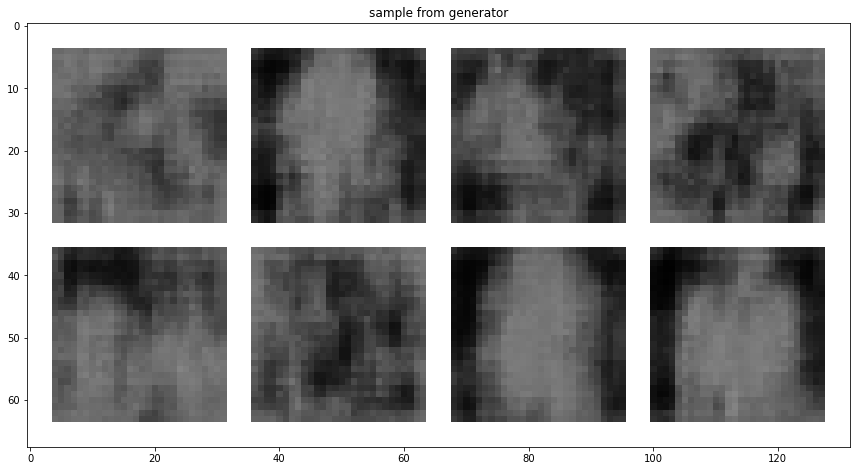

In [24]:
vae.eval()
sample = vae.generate(imgs_in=reference_imgs)
tmp = show_batch(sample, n_padding=4, figsize=(12,12), title='sample from generator')
exp.log_image("sample", tmp)
tmp

In [25]:
exp.stop()